In [1]:
import pandas as pd
import pickle
import numpy as np
import plotly.express as px
from GO_similarity import parse_background_probs, sim_go_families, sim_go_term_family
from goatools.obo_parser import GODag
import matplotlib.pyplot as plt
import re

In [2]:
cnts = pd.read_csv('/home/victor/bioinfo1/BioinformaticsAndPractice1/counts_and_GO.csv', comment='#')
cnts.dropna(axis=0, inplace=True)
cnts = cnts[(cnts['RNA-control.bam'] >= 30)& (cnts['CLIP-35L33G.bam'] >= 30) & (cnts['RNA-siLin28a.bam'] >= 30) & (cnts['RNA-siLuc.bam'] >= 30)&(cnts['RPF-siLuc.bam'] >= 80)].copy()
print(len(cnts))
cnts.head()

7777


,Geneid,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,clip_enrichment,ribosome_density_change,gene_symbol,GO_list,GO
5,ENSMUSG00000033845,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4843429;4843434;4844659;4846600;4847748;484774...,4844739;4847024;4844739;4847024;4847871;484787...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,8487,4014,1355,3022,2563,1859,3191,2.962362,0.494091,Mrpl15,"['GO:0005743', 'GO:0005840', 'GO:0032543', 'GO...",GO:0005743;GO:0005840;GO:0032543;GO:0015934;GO...
8,ENSMUSG00000033813,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4928037;4928261;4937693;4937693;4948250;494825...,4928199;4928726;4937755;4937755;4948355;494835...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,3017,1658,762,2130,2225,328,609,2.175853,0.562609,Tcea1,"['GO:0003676', 'GO:0008270', 'GO:0045944', 'GO...",GO:0003676;GO:0008270;GO:0045944;GO:0030218;GO...
11,ENSMUSG00000033793,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,5140241;5153303;5153333;5153347;5153355;515335...,5140367;5153501;5153848;5153501;5153501;515350...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,9746,1111,474,1260,1031,603,1128,2.343882,0.437418,Atp6v1h,"['GO:0000221', 'GO:0033176', 'GO:0033180', 'GO...",GO:0000221;GO:0033176;GO:0033180;GO:0030665;GO...
15,ENSMUSG00000025907,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,6276421;6276451;6284869;6284887;6285232;629382...,6276494;6276494;6285181;6285181;6285476;629396...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,14690,1520,280,694,903,132,251,5.428571,0.684272,Rb1cc1,"['GO:0006914', 'GO:0046330', 'GO:0005634', 'GO...",GO:0006914;GO:0046330;GO:0005634;GO:0005515;GO...
19,ENSMUSG00000051285,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,7159144;7159154;7159328;7159390;7190418;721786...,7159440;7159440;7159440;7159440;7190839;721796...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,6654,3508,529,2360,1775,208,138,6.631380,1.133628,Pcmtd1,"['GO:0004719', 'GO:1990756', 'GO:0008168', 'GO...",GO:0004719;GO:1990756;GO:0008168;GO:0031466;GO...


In [3]:
import pandas as pd
from goatools.obo_parser import GODag
from GO_similarity import parse_background_probs, sim_go_term_family

# ------------------------------------------------------------
# 0.  Load ontology and THREE namespace-specific back-prob files
# ------------------------------------------------------------
go_dag = GODag(
    "/home/victor/bioinfo1/BioinformaticsAndPractice1/go-basic.obo",
    optional_attrs={'relationship'}
)

bg_CC = parse_background_probs("swissprot_CC.tsv")   # Cellular-Component
bg_BP = parse_background_probs("swissprot_BP.tsv")   # Biological-Process
bg_MF = parse_background_probs("swissprot_MF.tsv")   # Molecular-Function

ns2bg = {
    "cellular_component":   bg_CC,
    "biological_process":   bg_BP,
    "molecular_function":   bg_MF,
}

# ------------------------------------------------------------
# 1.  ER-related reference terms (may span namespaces)
# ------------------------------------------------------------
ER_GO = {
    "GO:0005783",  # ER (CC)
    # "GO:0005789",  # ER membrane (CC)
    # "GO:0045047",  # protein targeting to ER (BP)
    # "GO:0006629",  # lipid ER-to-Golgi transport (BP)
    # "GO:0070971",  # ER exit site (CC)
}

# ------------------------------------------------------------
# 2.  helper: similarity of one gene’s GO list to ER family
#     – for each ER term, pick the matching background_probs
# ------------------------------------------------------------
def max_sim_to_er_family(term_list):
    """
    term_list – iterable / list of GO terms for ONE gene
    Returns the highest sim_go_term_family() score obtained
    among all ER_GO reference terms.  Namespace-correct
    background probabilities are used per comparison.
    """
    best = None
    for er_term in ER_GO:
        ns   = go_dag[er_term].namespace
        bg   = ns2bg.get(ns, {})          # fall back to empty dict
        score = sim_go_term_family(er_term, term_list, go_dag, bg)
        if score is not None and (best is None or score > best):
            best = score
    return best

# ------------------------------------------------------------
# 3.  apply to your DataFrame  (GO column holds list or string)
# ------------------------------------------------------------
def ensure_list(x):
    return x if isinstance(x, (list, set, tuple)) else str(x).split(";")

cnts["sim_to_ER"] = cnts["GO"].apply(ensure_list).apply(max_sim_to_er_family)
cnts.head()

/home/victor/bioinfo1/BioinformaticsAndPractice1/go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms; optional_attrs(relationship)


,Geneid,Chr,Start,End,Strand,Length,CLIP-35L33G.bam,RNA-control.bam,RNA-siLin28a.bam,RNA-siLuc.bam,RPF-siLin28a.bam,RPF-siLuc.bam,clip_enrichment,ribosome_density_change,gene_symbol,GO_list,GO,sim_to_ER
5,ENSMUSG00000033845,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4843429;4843434;4844659;4846600;4847748;484774...,4844739;4847024;4844739;4847024;4847871;484787...,-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;-;...,8487,4014,1355,3022,2563,1859,3191,2.962362,0.494091,Mrpl15,"['GO:0005743', 'GO:0005840', 'GO:0032543', 'GO...",GO:0005743;GO:0005840;GO:0032543;GO:0015934;GO...,0.484340
8,ENSMUSG00000033813,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,4928037;4928261;4937693;4937693;4948250;494825...,4928199;4928726;4937755;4937755;4948355;494835...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+,3017,1658,762,2130,2225,328,609,2.175853,0.562609,Tcea1,"['GO:0003676', 'GO:0008270', 'GO:0045944', 'GO...",GO:0003676;GO:0008270;GO:0045944;GO:0030218;GO...,0.559489
11,ENSMUSG00000033793,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,5140241;5153303;5153333;5153347;5153355;515335...,5140367;5153501;5153848;5153501;5153501;515350...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,9746,1111,474,1260,1031,603,1128,2.343882,0.437418,Atp6v1h,"['GO:0000221', 'GO:0033176', 'GO:0033180', 'GO...",GO:0000221;GO:0033176;GO:0033180;GO:0030665;GO...,0.481582
15,ENSMUSG00000025907,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,6276421;6276451;6284869;6284887;6285232;629382...,6276494;6276494;6285181;6285181;6285476;629396...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,14690,1520,280,694,903,132,251,5.428571,0.684272,Rb1cc1,"['GO:0006914', 'GO:0046330', 'GO:0005634', 'GO...",GO:0006914;GO:0046330;GO:0005634;GO:0005515;GO...,0.559489
19,ENSMUSG00000051285,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,7159144;7159154;7159328;7159390;7190418;721786...,7159440;7159440;7159440;7159440;7190839;721796...,+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;+;...,6654,3508,529,2360,1775,208,138,6.631380,1.133628,Pcmtd1,"['GO:0004719', 'GO:1990756', 'GO:0008168', 'GO...",GO:0004719;GO:1990756;GO:0008168;GO:0031466;GO...,0.064643


/tmp/ipykernel_2709773/146980314.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = cm.get_cmap("viridis")              # any matplotlib colormap


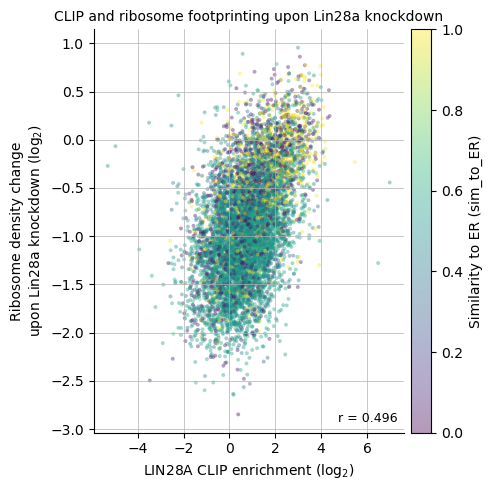

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.stats import pearsonr

# ------------------------------------------------------------------
# 1.  prepare the variables and a finite-row mask
# ------------------------------------------------------------------
x  = np.log2(cnts["clip_enrichment"])
y  = np.log2(cnts["ribosome_density_change"])

c  = cnts["sim_to_ER"]                       # colour dimension

finite = np.isfinite(x) & np.isfinite(y) & np.isfinite(c)
xv, yv, cv = x[finite].to_numpy(), y[finite].to_numpy(), c[finite].to_numpy()

# ------------------------------------------------------------------
# 2.  build a normalised colour map for sim_to_ER
#     (use vmin/vmax so the colour bar spans the actual data range)
# ------------------------------------------------------------------
norm   = colors.Normalize(vmin=cv.min(), vmax=cv.max())
cmap   = cm.get_cmap("viridis")              # any matplotlib colormap

# ------------------------------------------------------------------
# 3.  scatter plot, coloured by sim_to_ER
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 5))

scatter = ax.scatter(
    xv, yv,
    c      = cv,
    cmap   = cmap,
    norm   = norm,
    alpha  = 0.4,
    s      = 8,
    linewidth=0
)

ax.set_title('CLIP and ribosome footprinting upon Lin28a knockdown', fontsize=10)
ax.set_xlabel('LIN28A CLIP enrichment (log$_2$)')
ax.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log$_2$)')
ax.grid(linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# colour-bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label("Similarity to ER (sim_to_ER)")

# Pearson r (unchanged)
r, _ = pearsonr(xv, yv)
ax.text(
    0.98, 0.02, f'r = {r:.3f}',
    ha='right', va='bottom',
    transform=ax.transAxes,
    fontsize=9
)

plt.tight_layout()
plt.show()


<Axes: >

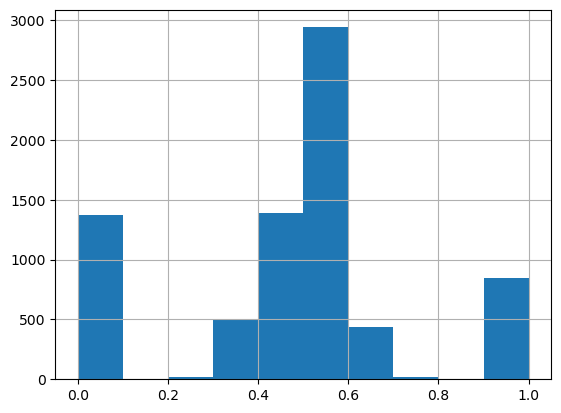

In [5]:
cnts["sim_to_ER"].hist()

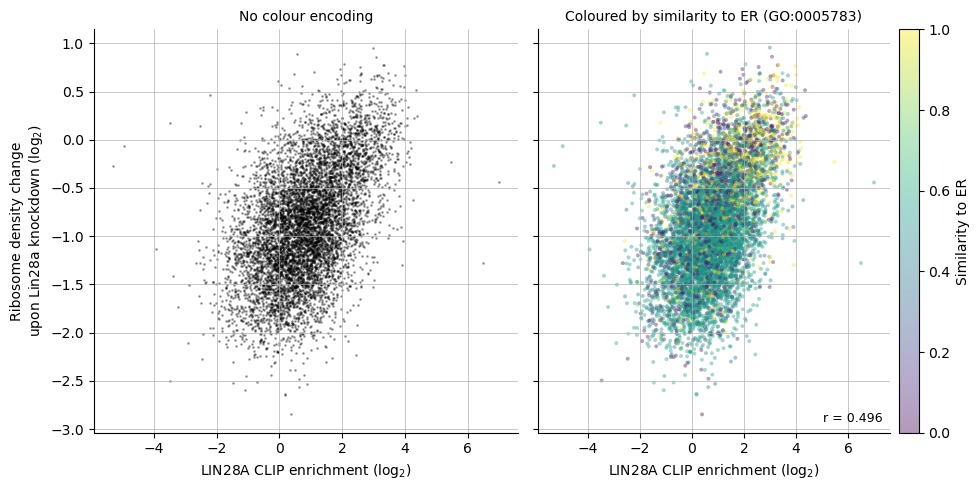

In [6]:
# ------------------------------------------------------------------
# 0.  we already have xv, yv, cv and the colormap/norm from your code
# ------------------------------------------------------------------

fig, (ax0, ax1) = plt.subplots(
    ncols=2, figsize=(10, 5), sharex=True, sharey=True
)

# ── left panel: ORIGINAL (monochrome) ─────────────────────────────
ax0.scatter(
    xv, yv,
    alpha=0.3, s=1, color = "black"
)
ax0.set_title("No colour encoding", fontsize=10)
ax0.set_xlabel('LIN28A CLIP enrichment (log$_2$)')
ax0.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log$_2$)')
ax0.grid(lw=.5)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

# ── right panel: COLOURED by sim_to_ER ───────────────────────────
sc = ax1.scatter(
    xv, yv,
    c=cv, cmap=cmap, norm=norm,
    alpha=0.4, s=8, linewidth=0
)
ax1.set_title("Coloured by similarity to ER (GO:0005783)", fontsize=10)
ax1.set_xlabel('LIN28A CLIP enrichment (log$_2$)')
ax1.grid(lw=.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# colour-bar for the right panel
cbar = fig.colorbar(sc, ax=ax1, pad=0.02)
cbar.set_label("Similarity to ER")

# ── global Pearson r on the coloured axis (unchanged) ────────────
from scipy.stats import pearsonr
r, _ = pearsonr(xv, yv)
ax1.text(
    0.98, 0.02, f'r = {r:.3f}',
    ha='right', va='bottom',
    transform=ax1.transAxes, fontsize=9
)

plt.tight_layout()
plt.show()
